# Versionamento

V2: 
<ul>
    <li>Inclusão da variável categórica x28 que está relacionada com o tipo de papel em produção</li>
    <li>Feature Selection</li>
    <li>Feature Scalling</li>
</ul>

V3:
<ul>
    <li>Ajuste de parâmetros dos modelos</li>
</ul>

# O problema

Paper manufacturing can be viewed as a continuous rolling process. During this process, sometimes the paper breaks. If a break happens, the entire process is stopped, the reel is taken out, any found problem is fixed, and the production is resumed. The resumption can take more than an hour.

The cost of this lost production time is significant for a mill. Even a 5% reduction in the break events will give a significant cost saving for a mill. The objective of the given problem is to predict such breaks in advance (early prediction) and identify the potential cause(s) to prevent the break. 

To build such a prediction model, we will use the data collected from the network of sensors in a mill.

This is a multivariate time series data with break as the response (a
binary variable).
The provided data has,
<ul>
    <li>18,398 records.</li>
    <li>Columns:</li>
        <ul>
        <li>time: the timestamp of the row</li>
        <li>y: the binary response variable. There are only 124 rows with y = 1, rest are y = 0.</li>
        <li>x1-x61: predictor variables. All the predictors are continuous variables, except x28 and x61. x61 is a binary variable, and x28 is a
        categorical variable. All the predictors are centered. Besides, the predictors are a mixture of raw materials and process variables. Their descriptions are omitted for data anonymity.
            Several sensors are placed in different parts of the machine along its length
and breadth. These sensors measure both raw materials (e.g. amount of pulp
fiber, chemicals, etc.) and process variables (e.g. blade type, couch vacuum,
rotor speed, etc.).</li>
        </ul>
</ul>

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import datetime

# Load Data

In [31]:
pwbdatafile = '..\\data\\processminer-rare-event-mts-data.csv'
pwbds = pd.read_csv(pwbdatafile)

In [32]:
pwbds['time']= pd.to_datetime(pwbds['time'])

## Cálculo do Remaining Usefull Lifecycle (RUL)

In [33]:
# Dates whith break
df_sub = sorted(pwbds[pwbds['y'] == 1]['time'].tolist())

In [34]:
# variable to store all days
breakSubIdx=0
breakLstIdx=0
breakList = pwbds['y'].tolist()
nextbreak = []
for v1 in pwbds['time'].tolist():
    if((breakList[breakLstIdx] == 1)):
#        print ('1')
        nextbreak.append(v1)
        breakSubIdx = breakSubIdx+1
    else:
#        print('0')
        if (breakSubIdx < len(df_sub)):
            nextbreak.append(df_sub[breakSubIdx])
        else:
            nextbreak.append(df_sub[breakSubIdx-1])
    breakLstIdx = breakLstIdx+1
pwbds['nextbreaktime'] = pd.Series(nextbreak)

In [35]:
pwbds['RUL']=round((pwbds['nextbreaktime']-pwbds['time']).dt.total_seconds()/60,2)
pwbds.drop(pwbds[pwbds.RUL < 0].index, inplace=True)
pwbds.drop(['time','nextbreaktime'], axis=1, inplace=True)

## Marcação de falha no próximo período (próxima hora)

Using RUL, we can create a label indicating time to failure. We define a boolean (True\False) value for NEXT_H indicating the engine will fail within 60 minutes (RUL  <=60 ). 

We can also define a multiclass MULTI  ∈{0,1,2}  indicating {Healthy, RUL <=60, RUL <=120} minutes.

In [36]:
pwbds['NEXT_H'] = np.where(pwbds['RUL'] <= 60, 1, 0 )

In [37]:
pwbds['NEXT_H'].value_counts()

0    14877
1     3017
Name: NEXT_H, dtype: int64

# Feature Selection and Scaling

In [38]:
# Feature Selection
# List of considered Features
# Descartando o Grupo A (variáveis que caem abrubtamente)
FEATURES = [
    'x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x13','x14','x15','x17','x18','x19','x20',
    'x21','x22','x24','x26','x27','x28','x29','x30','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x54','x55','x56','x57','x60',
    ]

# Create the dataset with features and filter the data to the list of FEATURES
pwbds_filtered = pwbds[FEATURES]

# Print the tail of the dataframe
pwbds_filtered.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x46,x47,x48,x49,x50,x54,x55,x56,x57,x60
17889,0.051116,2.476604,1.527155,161.052222,0.046178,41.906197,-0.009339,-0.000993,0.110023,0.021628,...,0.251298,67.346772,0.012697,9.200203,-2.986095,1.897396,84.523014,-30.168570,-1.348561,-0.005688
17890,0.122141,2.360784,1.540863,170.833289,-0.025370,48.537056,-0.009339,-0.000993,0.110023,0.011557,...,0.065130,54.753144,0.012987,9.072731,-2.986095,2.444188,82.112857,-28.508627,-0.982289,-0.005702
17891,0.068225,2.513360,1.259075,173.774878,-0.096919,51.046517,-0.009339,-0.000993,0.110023,0.011557,...,0.023382,58.629975,0.013277,8.391762,-2.986095,2.446941,75.939762,-20.985724,-1.165393,-0.005717
17892,0.193702,2.404968,1.115587,175.885504,-0.168452,52.827950,-0.009339,-0.000993,0.119788,0.011557,...,0.109628,57.240815,0.013567,7.710823,-2.986095,2.449692,71.452701,-20.228964,-0.664906,-0.005731
17893,0.075007,-13.796615,-16.995079,177.938849,-0.240000,57.281533,-0.009339,-0.000993,0.119788,0.011557,...,-0.264514,55.707185,0.013857,28.817513,-2.986095,2.452444,80.604312,-19.472189,-1.226490,-0.005746


In [39]:
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

# Get the number of rows in the data
nrows = pwbds_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(pwbds_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
pwbds_scaled = pd.DataFrame(
    np_data_scaled,
    columns=FEATURES
)
pwbds_scaled['NEXT_H'] = pwbds['NEXT_H']

(17894, 50)


# Shaping & Splitting

In [40]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix-1]
        
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

# Modeling 2: Binary Classification - Break in the next hour

## Dataset for model 2

In [41]:
pwbds_scaled_copy = pwbds_scaled

In [12]:
pwbds_m2 = pwbds_scaled
yds_m2 = pwbds.pop('NEXT_H')

In [13]:
num_steps = pwbds_m2.shape[1]
x_new, y_new = lstm_data_transform(pwbds_m2, yds_m2, num_steps=num_steps)
print ("The new shape of x is", x_new.shape)

The new shape of x is (17843, 51, 51)


In [14]:
num_steps

51

In [16]:
train_ind = int(0.8 * pwbds.shape[0])
x_train = x_new[:train_ind]
y_train = y_new[:train_ind]
x_test = x_new[train_ind:]
y_test = y_new[train_ind:]

# Model 2

In [17]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\pyth

In [18]:
# LSTM model
model = Sequential()

# The first layer
model.add(LSTM(
         input_shape=(num_steps, x_train.shape[2]),
         units=100,
         return_sequences=True))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# The second layer
model.add(LSTM(
          units=50,
          return_sequences=False))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# Dense sigmoid layer
model.add(Dense(units=1, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Verify the architecture 
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 51, 100)           60800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 51, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 91,051
Trainable params: 91,051
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# EarlyStopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [20]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([12132,  2183], dtype=int64))

In [21]:
x_train.shape

(14315, 51, 51)

In [22]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=10,
#    batch_size=200,
#    validation_split=0.10,
    callbacks = [callback])


Epoch 1/10
14315/14315 [==============================] - 24s 2ms/step - loss: 0.0970 - accuracy: 0.9680
Epoch 2/10
14315/14315 [==============================] - 27s 2ms/step - loss: 0.0067 - accuracy: 0.9987
Epoch 3/10
14315/14315 [==============================] - 28s 2ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 4/10
14315/14315 [==============================] - 27s 2ms/step - loss: 6.0590e-04 - accuracy: 0.9999
Epoch 5/10
14315/14315 [==============================] - 27s 2ms/step - loss: 2.1340e-04 - accuracy: 1.0000
Epoch 6/10
14315/14315 [==============================] - 28s 2ms/step - loss: 1.0713e-04 - accuracy: 1.0000
Epoch 7/10
14315/14315 [==============================] - 28s 2ms/step - loss: 9.1020e-05 - accuracy: 1.0000
Epoch 8/10
14315/14315 [==============================] - 28s 2ms/step - loss: 6.1336e-05 - accuracy: 1.0000
Epoch 9/10
14315/14315 [==============================] - 28s 2ms/step - loss: 5.1569e-05 - accuracy: 1.0000
Epoch 10/10
14315/14315 [=====

Text(0.5, 0, 'epochs')

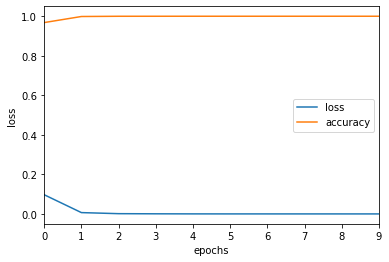

In [23]:
# Plot History
pd.DataFrame(history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [24]:
#scores_2 = model.evaluate(x_test, y_test, verbose=1, batch_size=200)
scores_2 = model.evaluate(x_test, y_test, verbose=1)
print('Training Accurracy: {}'.format(scores_2[1]))

3528/3528 [==============================] - 2s 494us/step
Training Accurracy: 1.0


In [25]:
# make predictions and compute confusion matrix
#y_pred = model.predict_classes(x_test,verbose=1, batch_size=200)
y_pred = model.predict_classes(x_test,verbose=1)
y_true = y_test
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

3528/3528 [==============================] - 2s 480us/step
Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[2695,    0],
       [   0,  833]], dtype=int64)

In [26]:
# compute precision and recall
precision_test = precision_score(y_true, y_pred)
recall_test = recall_score(y_true, y_pred)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Precision:  1.0 
 Test Recall:  1.0 
 Test F1 Score: 1.0


In [27]:
cm = confusion_matrix(y_true, y_pred)

In [28]:
cmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred),
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)
print(cmtx)

        pred:0  pred:1
true:0    2695       0
true:1       0     833


In [ ]:
np.unique(y_test,return_counts=True)

# Random Forest

In [42]:
pwbds_scaled_copy.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x47,x48,x49,x50,x54,x55,x56,x57,x60,NEXT_H
0,0.608636,0.373556,0.413587,0.511470,0.256705,0.689107,0.201421,0.314546,0.018072,0.019907,...,0.207222,0.587033,0.468376,0.841714,0.222937,0.397786,0.551731,0.823712,0.474630,0
1,0.623115,0.375140,0.415857,0.515627,0.255016,0.694199,0.201421,0.314546,0.018072,0.019907,...,0.206991,0.587064,0.470738,0.841608,0.222886,0.382678,0.559875,0.783305,0.474885,0
2,0.606763,0.371061,0.406039,0.512429,0.253327,0.696653,0.206138,0.314546,0.027062,0.026475,...,0.206237,0.587094,0.476883,0.841501,0.222835,0.379259,0.568019,0.826988,0.475140,0
3,0.597663,0.368784,0.415703,0.510959,0.251706,0.694840,0.202050,0.314546,0.030090,0.029810,...,0.204728,0.587125,0.476006,0.841395,0.222784,0.375840,0.557788,0.849920,0.475395,0
4,0.592399,0.369048,0.406625,0.514162,0.250483,0.697534,0.201421,0.314546,0.027062,0.029810,...,0.203219,0.587155,0.475128,0.841288,0.222734,0.372421,0.558239,0.830264,0.475686,0


In [43]:
train_ind = int(0.8 * pwbds_scaled_copy.shape[0])
x_train = pwbds_scaled_copy[:train_ind]
y_train = pwbds_scaled_copy.NEXT_H[:train_ind]
x_test = pwbds_scaled_copy[train_ind:]
y_test = pwbds_scaled_copy.NEXT_H[train_ind:]

In [44]:
from sklearn.ensemble import RandomForestClassifier as rfc
clf_rf = rfc(random_state=0).fit(x_train, y_train)

In [45]:
clf_rf.score(x_test, y_test)

1.0

In [46]:
y_pred = clf_rf.predict(x_test)

In [47]:
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_test, y_pred)
cm

Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[2745,    0],
       [   0,  834]], dtype=int64)